# **Elasticity equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Elasticity equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [19]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [20]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

In [21]:
# Load neccessary modules.
#from google.colab import files

#import numpy as np
#import time

# Install FEniCS
#try:
#    import dolfin
#except ImportError as e:
 #   !apt-get install -y -qq software-properties-common
 #   !add-apt-repository -y ppa:fenics-packages/fenics
 #   !apt-get update -qq
 #   !apt install -y --no-install-recommends fenics
#    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
#    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
#    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
#    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
#    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
#    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
#    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
#    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
#    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
#    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
#    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
#    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
#    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
#    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
#    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
#    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
#    !pip3 -q install --upgrade sympy
#    import dolfin

#from dolfin import *; from mshr import *

#import dolfin.common.plotting as fenicsplot

#from matplotlib import pyplot as plt

# **Introduction**

The Elasticity equations take the form

$-\nabla \cdot \sigma = f$

together with suitable boundary conditions.

To derive the weak form of the equations, multiply the equation by $v\in V$, and then integrate over the domain $\Omega$ and use Green's formula
$
(-\nabla \cdot \sigma ,v) = (\nabla \sigma , \nabla v) 
- <\sigma \cdot n, v>_{\Gamma}
$

To model 

We seek a finite element approximation $u\in V$ such that 

$(\nabla \sigma,\nabla v) - <\sigma \cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $v \in V$. 



# **Method**

Here we set up the domain, which is a rectangular mesh with 3 holes in it. The holes are then moved to the right, where we use an elasticity model to determine how to deform our mesh grid in response.

The youngs modulus, poission ratio and movement of the cylinders were then varied to see how this affected the grid change.

**Define domain and mesh**

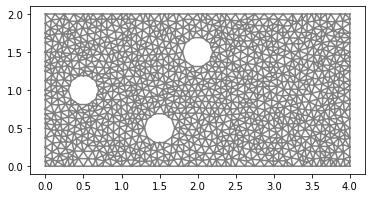

In [22]:
# Define rectangular domain 
L = 4.0
H = 2.0

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [23]:
# Generate finite element space
VE = VectorElement("CG", mesh.ufl_cell(), 1)

V = FunctionSpace(mesh, VE)

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V) 

d = Function(V)

**Define boundary conditions**

In [24]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

#Here we define a displacement variable for that we can vary how mych the cylinders move
#dispX = 0.5
#dispY = 0.0
dispX = 0.0
dispY = 0.3

bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
bcu_upper0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upper1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_lower0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_lower1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), dispX, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), dispY, dbc_objects)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_upper0, bcu_upper1, bcu_lower0, bcu_lower1, bcu_obj0, bcu_obj1]

# **Results**

**Define and solve variational problem**

In [25]:
f = Expression(("0.0","0.0"), element = V.ufl_element())

dim = u.geometric_dimension()
E = 1.0e10            # This is the material constant, or young's modulus, relative deformation / relative force to area, or strain/stress
nu = 0.3             # This is poissons ratio, the ratio of deformation in the x plane to the yplane
mu = E*0.5/(1+nu)     
lambda_ = nu*E/((1.0+nu)*(1.0-2.0*nu))

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)

def sigma(u):
    #return 2.0*mu*epsilon(u)
    return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)

# Define variational problem on residual form: r(u,v) = 0
residual = ( inner(sigma(u), epsilon(v))*dx - inner(f, v)*dx )

au = lhs(residual)
Lu = rhs(residual)

A = assemble(au)
b = assemble(Lu)

[bc.apply(A, b) for bc in bcu]
[bc.apply(d.vector()) for bc in bcu]

solve(A, d.vector(), b, "bicgstab", "default")

19

**Visualize solution and export files**

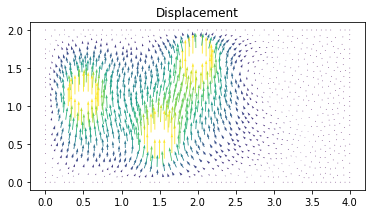

In [26]:
u1 = project(d, V)

# Plot solution
plt.figure()
plot(u1, title="Displacement")

plt.show()

**Update mesh**

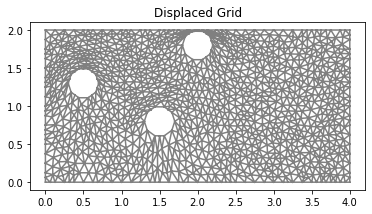

In [27]:
ALE.move(mesh, d)
plt.figure()
plot(mesh, title="Displaced Grid")
plt.show()

##Figure 1

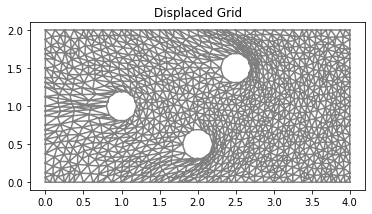
###Caption: Displaced Grid with Poisson ratio $\nu = 0.3$, and Young's modulus $ E = 10^{10}$, when the cylinders are displaced to the right by 0.5.

##Figure 2

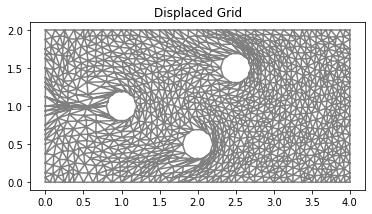
###Caption: Displaced grid with Poisson ratio $\nu = 0.45$ and Young's modulus $E=10^{10}$, when the cylinders are displaced to the right by 0.5.

##Figure 3

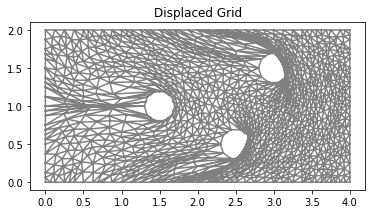
###Caption: Displaced grid with Poisson ratio $\nu = 0.3$ and Young's modulus $E=10^{10}$, when the cylinders are displaced to the right by 1.0.

##Figure 4

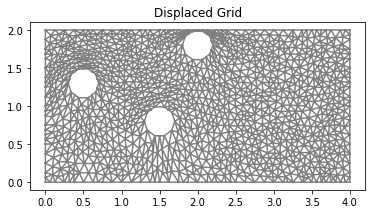
###caption: Displaced grid with Poisson ratio $\nu = 0.3$ and Young's modulus $E=10^{10}$, when the cylinders are displaced in the positive y direction by 0.3.

# **Discussion**

We can see the elastic response of the grid in Figure 1, where Young's modulus was set to be $E = 10^{10}$ and Poissons ration $\nu = 0.3$, where the cylders have been moved to the right. We see here that the grid is stretched to the left of the cylinders and squashed to the right of the cyldinders, and that far away from the cylinders there is not any visible change in the grid structure, which is often something which is desired when using an elastic model for grid deformation. When only Young's modulus was changed around no real difference in how the grid was displaced could be observed. This is however not too surprising since we have a fixed displacement of the cylinders, and Young's modulus mainly has to do with how much force is required to displace an elastic material. We do however expect a change when we vary the Poisson ratio, since this should affect how much the grid is squashed in the transverse direction. When the Poisson ratio was changed to 0.45, see Figure 2, we see what we expect, the grid is heavily compressed along the y-axis directly to the left of the cylinders, most visible in the leftmost cylinder.

When the displacement was increase from 0.5 to 1.0, see Figure 3, we first observe that to the left the cylinders the compression in the Y direction is greatly increased, however the compression to the right of the cylinders in the x-direction has become something that does not look physical, it visually looks like the cylinders have went underneath the grid, at least for the 2 rightmost cylinders. The leftmost one seems to have an okay response around it, but its likely due to the fact that it moves into the area that was streched by the other cylinders. This non-physical phenomena is likely due to the fact that the linear model that we are using is only accurate for small deformations, and we seem to have stretched the grid too much for the model to handle.

Lastly the displacement was adjusted to intead a displacement of 0.3 in the postivive y-direction, which can be seen in Figure 4, however this does not really give any new insight but i does confirm that the model works properly for these displacements/deformations as well.